In [1]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Naïve Bayes

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes theorem with strong *naive* assumption of conditional independence between every pair of features. Bayes theorem states the following relationship, given class variable $y$ and dependent feature vector $x_1$ through $x_n$, :

$$P(y \mid x_1, \dots, x_n) = \frac{P(y) P(x_1, \dots x_n \mid y)}
                                 {P(x_1, \dots, x_n)}$$

Using the naive conditional independence assumption that

$$P(x_i | y, x_1, \dots, x_{i-1}, x_{i+1}, \dots, x_n) = P(x_i | y),$$

for all $i$, this relationship is simplified to

$$P(y \mid x_1, \dots, x_n) = \frac{P(y) \prod_{i=1}^{n} P(x_i \mid y)}
                                 {P(x_1, \dots, x_n)}$$

Since $P(x_1, \dots, x_n)$ is constant given the input, we can use the
following classification rule:

$$P(y \mid x_1, \dots, x_n) \propto P(y) \prod_{i=1}^{n} P(x_i \mid y)$$$$\Downarrow$$$$\hat{y} = \arg\max_y P(y) \prod_{i=1}^{n} P(x_i \mid y),$$

and we can use Maximum A Posteriori (MAP) estimation to estimate $P(y)$ and $P(x_i \mid y)$; the former is then the relative frequency of class $y$ in the training set.

The different naive Bayes classifiers differ mainly by the assumptions they make regarding the distribution of $P(x_i \mid y)$.

In spite of their apparently over-simplified assumptions, naive Bayes classifiers have worked quite well in many real-world situations, famously document classification and spam filtering. They require a small amount of training data to estimate the necessary parameters.

Naive Bayes learners and classifiers can be extremely fast compared to more sophisticated methods. The decoupling of the class conditional feature distributions means that each distribution can be independently estimated as a one dimensional distribution. This in turn helps to alleviate problems stemming from the curse of dimensionality.

On the flip side, although naive Bayes is known as a decent classifier, it is known to be a bad estimator, so the probability outputs from `predict_proba` are not to be taken too seriously.


## Gaussian Naive Bayes

`GaussianNB` implements the Gaussian
Naive Bayes algorithm for classification. The likelihood of the features is assumed to be Gaussian:

$$P(x_i \mid y) = \frac{1}{\sqrt{2\pi\sigma^2_y}} \exp\left(-\frac{(x_i - \mu_y)^2}{2\sigma^2_y}\right)$$

The parameters $\sigma_y$ and $\mu_y$ are estimated using maximum
likelihood.


Number of mislabeled points out of a total 50 points : 3
Testing Accuracy : 94.0 %



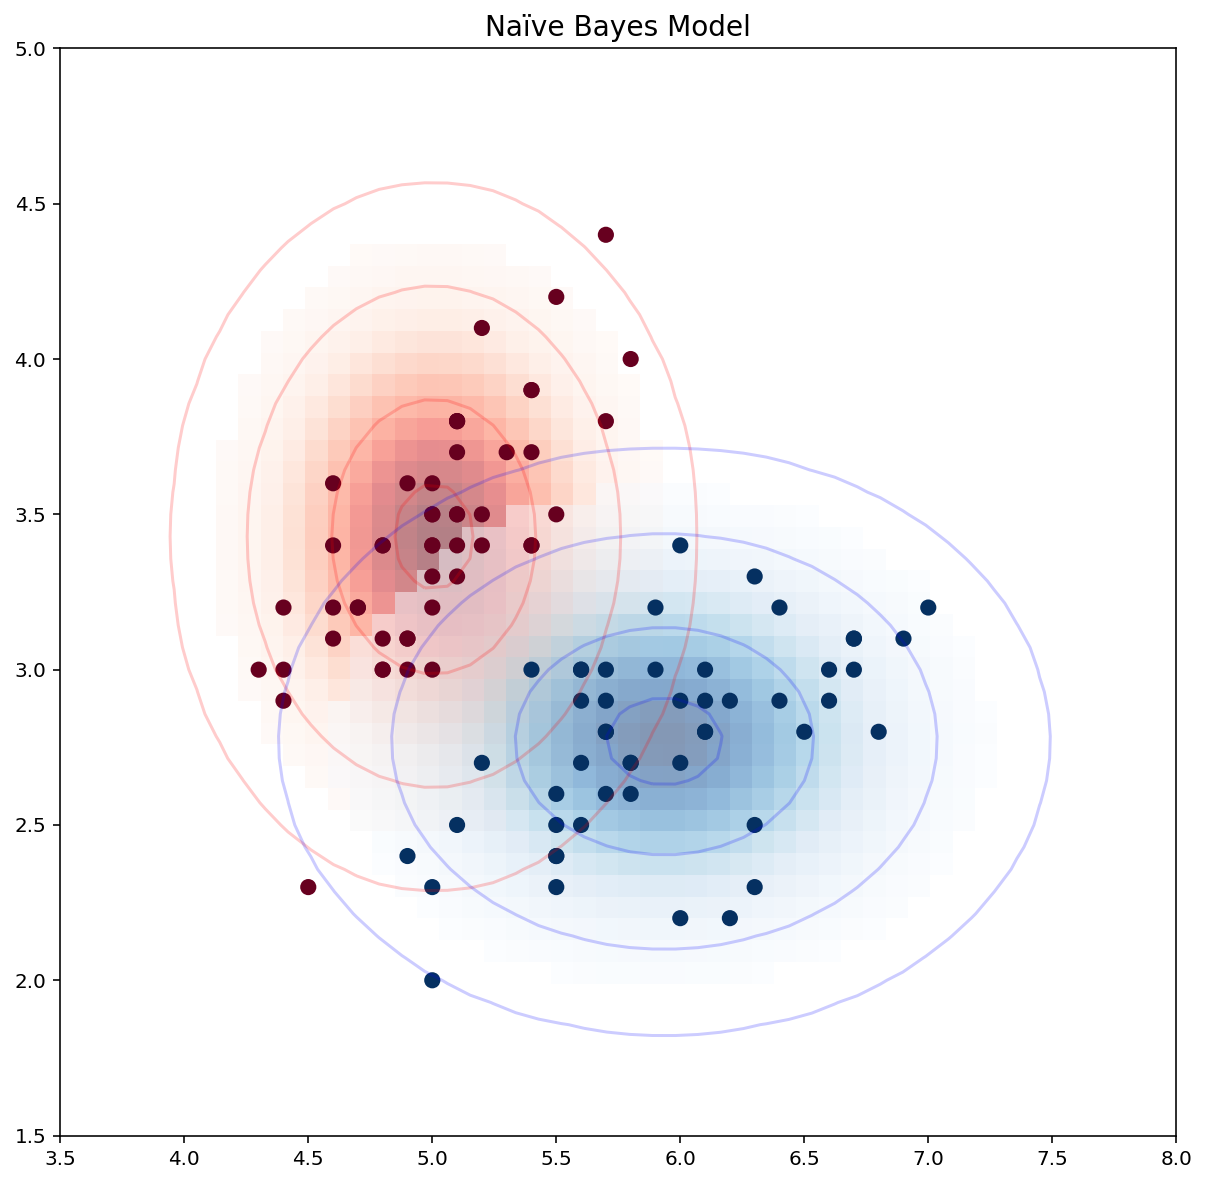

In [88]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB


def gaussian_naive_bayes():
    X, y = load_iris(return_X_y=True)
    # Simplify dataset to two classes & two features
    X_list = []
    y_list = []
    for X_i, y_i in zip(X, y):
        if y_i <= 1:
            X_list.append(X_i)
            y_list.append(y_i)
    X = np.array(X_list)[:, :2]
    y = np.array(y_list)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, random_state=0)
    gnb = GaussianNB()
    y_pred = gnb.fit(X_train, y_train).predict(X_test)
    print("Number of mislabeled points out of a total {} points : {}".format(
        X_test.shape[0], (y_test != y_pred).sum()))

    # Plotting helper function
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
    ax.set_title('Naïve Bayes Model', size=14)

    xlim = (3.5, 8)
    ylim = (1.5, 5)

    xg = np.linspace(xlim[0], xlim[1], 50)
    yg = np.linspace(ylim[0], ylim[1], 50)
    xx, yy = np.meshgrid(xg, yg)
    Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

    for label, color in enumerate(['red', 'blue']):
        mask = (y == label)
        mu, std = X[mask].mean(0), X[mask].std(0)
        norm = Xgrid - mu
        P = np.exp(-0.5 * (norm) ** 2 / std ** 2).prod(1)
        Pm = np.ma.masked_array(P, P < 0.03)
        ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5,
                      cmap=color.title() + 's')
        ax.contour(xx, yy, P.reshape(xx.shape),
                   levels=[0.01, 0.1, 0.5, 0.9],
                   colors=color, alpha=0.2)

    ax.set(xlim=xlim, ylim=ylim)

    y_test_predict = gnb.predict(X_test)
    print('Testing Accuracy : {} %\n'.format(
        100 * accuracy_score(y_test, y_test_predict)))


gaussian_naive_bayes()


## Multinomial Naive Bayes

`MultinomialNB` implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice). The distribution is parametrized by vectors $\theta_y = (\theta_{y1},\ldots,\theta_{yn})$ for each class $y$, where $n$ is the number of features (in text classification, the size of the vocabulary) and $\theta_{yi}$ is the probability $P(x_i \mid y)$ of feature $i$ appearing in a sample belonging to class $y$.

The parameters $\theta_y$ is estimated by a smoothed version of maximum
likelihood, i.e. relative frequency counting:

$$\hat{\theta}_{yi} = \frac{ N_{yi} + \alpha}{N_y + \alpha n}$$

where $N_{yi} = \sum_{x \in T} x_i$ is the number of times feature $i$
appears in a sample of class $y$ in the training set $T$, and
$N_{y} = \sum_{i=1}^{n} N_{yi}$ is the total count of all features for
class $y$.

The smoothing priors $\alpha \ge 0$ accounts for features not present in
the learning samples and prevents zero probabilities in further
computations. Setting $\alpha = 1$ is called Laplace smoothing, while
$\alpha < 1$ is called Lidstone smoothing.

In [89]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix


def multinomial_naive_bayes():
    X, y = load_iris(return_X_y=True)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, random_state=0)

    clf = MultinomialNB()
    clf.fit(X_train, y_train)

    y_test_predict = clf.predict(X_test)
    print('Testing Accuracy : {} %\n'.format(
        100 * accuracy_score(y_test, y_test_predict)))


multinomial_naive_bayes()

Testing Accuracy : 60.0 %



## Complement Naive Bayes

`ComplementNB` implements the complement naive Bayes (CNB) algorithm. CNB is an adaptation of the standard multinomial naive Bayes (MNB) algorithm that is particularly suited for imbalanced data sets. Specifically, CNB uses statistics from the *complement* of each class to compute the model\'s weights. The inventors of CNB show empirically that the parameter estimates for CNB are more stable than those for MNB. Further, CNB regularly outperforms MNB (often by a considerable margin) on text classification tasks. The procedure for calculating the weights is as follows:

$$\hat{\theta}_{ci} = \frac{\alpha_i + \sum_{j:y_j \neq c} d_{ij}}
                         {\alpha + \sum_{j:y_j \neq c} \sum_{k} d_{kj}}$$$$w_{ci} = \log \hat{\theta}_{ci}$$$$w_{ci} = \frac{w_{ci}}{\sum_{j} |w_{cj}|}$$

where the summations are over all documents $j$ not in class $c$,
$d_{ij}$ is either the count or tf-idf value of term $i$ in document
$j$, $\alpha_i$ is a smoothing hyperparameter like that found in MNB,
and $\alpha = \sum_{i} \alpha_i$. The second normalization addresses the
tendency for longer documents to dominate parameter estimates in MNB.
The classification rule is:

$$\hat{c} = \arg\min_c \sum_{i} t_i w_{ci}$$

i.e., a document is assigned to the class that is the *poorest*
complement match.

In [90]:
import numpy as np
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import accuracy_score, confusion_matrix


def complement_naive_bayes():
    X, y = load_iris(return_X_y=True)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, random_state=0)

    clf = ComplementNB()
    clf.fit(X_train, y_train)

    y_test_predict = clf.predict(X_test)
    print('Testing Accuracy : {} %\n'.format(
        100 * accuracy_score(y_test, y_test_predict)))


complement_naive_bayes()

Testing Accuracy : 60.0 %



## Bernoulli Naive Bayes

`BernoulliNB` implements the naive Bayes
training and classification algorithms for data that is distributed
according to multivariate Bernoulli distributions; i.e., there may be
multiple features but each one is assumed to be a binary-valued
(Bernoulli, boolean) variable. Therefore, this class requires samples to
be represented as binary-valued feature vectors; if handed any other
kind of data, a `BernoulliNB` instance may binarize its input (depending
on the `binarize` parameter).

The decision rule for Bernoulli naive Bayes is based on

$$P(x_i \mid y) = P(i \mid y) x_i + (1 - P(i \mid y)) (1 - x_i)$$

which differs from multinomial NB\'s rule in that it explicitly
penalizes the non-occurrence of a feature $i$ that is an indicator for
class $y$, where the multinomial variant would simply ignore a
non-occurring feature.

In the case of text classification, word occurrence vectors (rather than
word count vectors) may be used to train and use this classifier.
`BernoulliNB` might perform better on some datasets, especially those
with shorter documents. It is advisable to evaluate both models, if time
permits.

In [91]:
import numpy as np
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix


def bernoulli_naive_bayes():
    X, y = load_iris(return_X_y=True)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, random_state=0)

    clf = BernoulliNB()
    clf.fit(X_train, y_train)

    y_test_predict = clf.predict(X_test)
    print('Testing Accuracy : {} %\n'.format(
        100 * accuracy_score(y_test, y_test_predict)))


bernoulli_naive_bayes()

Testing Accuracy : 28.000000000000004 %

